<a href="https://colab.research.google.com/github/asifsmtp1/quantum-svm/blob/main/sklearn_iris_on_qsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade qiskit

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM, VQC

In [3]:
# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns; sns.set()
import pandas as pd

In [63]:
training_size=20
test_size=10
n=2
plot_data=True
class_labels = [r'A', r'B', r'C']
feature_dim=2

In [64]:
iris = datasets.load_iris() 
data = iris.data 
target = iris.target 
names = iris.target_names

In [65]:
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

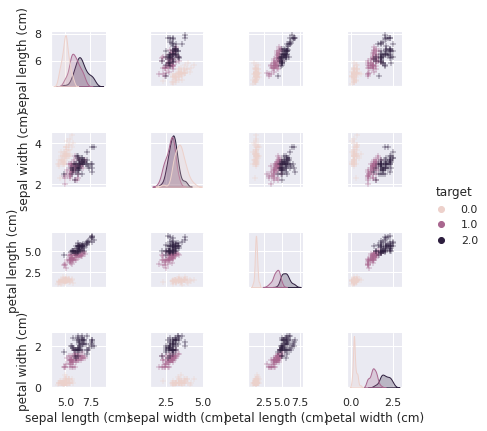

In [66]:
sns.pairplot(iris_df,hue='target',  height=1.5, markers='+');

In [67]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [68]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=1, random_state=42)

In [69]:
# Now we standardize for gaussian around 0 with unit variance
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [70]:
# Now reduce number of features to number of qubits
pca = PCA(n_components=n).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [71]:
# Scale to the range (-1,+1)
samples = np.append(X_train, X_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
X_train = minmax_scale.transform(X_train)
X_test = minmax_scale.transform(X_test)

In [72]:
# Pick training size number of samples from each distro
training_input = {key: (X_train[y_train == k, :])[:training_size]
                  for k, key in enumerate(class_labels)}
test_input = {key: (X_test[y_test == k, :])[:test_size]
                  for k, key in enumerate(class_labels)}

In [91]:
from qiskit.aqua.components.multiclass_extensions import AllPairs
seed = 10598

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')

qsvm = QSVM(feature_map, training_input, test_input,multiclass_extension = AllPairs())

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

#print("testing success ratio: ", result['testing_accuracy'])

In [74]:
#Create the SVM model
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
#Fit the model for the data

classifier.fit(X_train, y_train)

#Make the prediction
y_pred = classifier.predict(X_test)

In [86]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)


In [89]:
print("QSVM Accuracy: {:.2f} %".format(result['testing_accuracy']*100))

print("SVM Accuracy : {:.2f} %".format(accuracies.mean()*100))



QSVM Accuracy: 100.00 %
SVM Accuracy : 91.86 %


In [90]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright